<a href="https://colab.research.google.com/github/rifqoi/Inacure-Machine-Learning/blob/main/03.1.vgg16-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset from Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip  drive/Shareddrives/Bangkit\ Capstone/leaf_datasets.zip -d .

Mounted at /content/drive


# Import Libraries

In [2]:
import re
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import cv2
from google.colab.patches import cv2_imshow


tf.keras.utils.set_random_seed(42)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copyfile

# List directories for each datasets

In [3]:
dataset_dir = f"/content/drive/Shareddrives/Bangkit Capstone/Final_Split_Datasets"
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

# List Images

In [4]:
def list_images():
  classes_dirs = os.listdir(train_dir)
  for folder in classes_dirs:
    train_classes = os.listdir(os.path.join(train_dir, folder))
    validation_classes = os.listdir(os.path.join(validation_dir, folder))
    test_classes = os.listdir(os.path.join(test_dir, folder))
    print(f"{folder}: \n \t{len(train_classes)} train images, {len(validation_classes)} validation images, and {len(test_classes)} test images,  total {len(train_classes) + len(validation_classes) + len(test_classes)} images")
    print()
list_images()

Lemon: 
 	151 train images, 42 validation images, and 23 test images,  total 216 images

Mangga: 
 	304 train images, 86 validation images, and 45 test images,  total 435 images

Jambu Biji: 
 	338 train images, 96 validation images, and 50 test images,  total 484 images

Jamblang: 
 	226 train images, 64 validation images, and 34 test images,  total 324 images

Delima: 
 	251 train images, 71 validation images, and 37 test images,  total 359 images

Anggur: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images

Kedelai: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images

Apel: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images

Ceri: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images



# Create a model class to prevent code redundancy

In [5]:
class Model:
  def __init__(self, model, config):
    self.config = config
    self.batch_size = self.config['batch_size']
    # self.trainable = self.config['trainable']
    self.epochs = self.config['epochs']
    self.classes= self.config['classes']
    self.input_shape = self.config['input_shape']
    self.base_model = model

  def img_segmentation(self,img):
    # img = cv2.resize(img, (224,224))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # find the green color 
    mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
    # find the brown color
    mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
    # find the yellow color in the leaf
    mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))
    
    # find any of the three colors(green or brown or yellow) in the image
    mask = cv2.bitwise_or(mask_green, mask_brown)
    mask = cv2.bitwise_or(mask, mask_yellow)
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)
    
    return res
    
    

  def train_val_generators(self, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, preprocess_input=None):
    train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range = 25,
      zoom_range = [0.5, 1.1],
      width_shift_range=0.15, 
      shear_range= 0.15,
      height_shift_range=0.15,
      horizontal_flip=True,
      vertical_flip= True,
      fill_mode='nearest',)
  
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32, 
                                                        seed=42,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  
    validation_datagen = ImageDataGenerator(rescale = 1/255,)
  
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))
    test_datagen = ImageDataGenerator(rescale= 1./255.)
  
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                  batch_size=32,
                                                                  shuffle=False, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))

    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.test_generator = test_generator
    return train_generator, validation_generator, test_generator

  def set_generator(self, train_generator, val_generator, test_generator, ):
    self.train_generator = train_generator
    self.valdation_generator = validation_generator
    self.test_generator = test_generator
  

  def build_model(self, compile_config, custom_layer = None):

    compile_config['metrics'] = [metric.replace("accuracy", "acc") for metric in compile_config['metrics']]

    layers = []
    
    # Append base model to layers_list
    layers.append(self.base_model)

    flatten_layer = tf.keras.layers.Flatten()
    layers.append(flatten_layer)

    if custom_layer is None:
      layers.append(tf.keras.layers.Dense(512, activation='relu'))
    else: 
      for layer in custom_layer:
        layers.append(layer)
    
    prediction_layer = tf.keras.layers.Dense(self.classes, activation='softmax')
    layers.append(prediction_layer)

    self.model = tf.keras.models.Sequential(layers)

    self.model.compile(**compile_config)
    self.model.summary()

    return self.model

  def train(self, model_name, reduce_lr_config=None):
    self.model_name = model_name
    model_filepath = model_name +'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    callbacks = [model_checkpoint, model_early_stopping]
    if reduce_lr_config is not None:
      reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_config)
      callbacks.append(reduce_lr)
    model_history = self.model.fit(self.train_generator, epochs = self.epochs,
                                   validation_data = self.validation_generator,callbacks=callbacks , verbose=1)
    self.history = model_history
    return model_history

  def plot_history(self):
    acc = self.history.history['acc']
    val_acc = self.history.history['val_acc']
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.subplot()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
  
    plt.subplot()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss,  label='Validation Loss')
    plt.legend()
    plt.show()
    
    plt.show()

  def evaluate_model(self):
    evaluate = self.model.evaluate(self.test_generator)
    print('Loss of the model is - ', evaluate[0])
    print('Accuracy of the model is - ', evaluate[1]*100, '%')
  
    classes =  list(self.test_generator.class_indices.keys())
    Y_pred = self.model.predict(self.test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
    print('Confusion Matrix')
    conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
    ax = sns.heatmap(df_cm, annot=True, cmap='Blues')
  
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
  
  def find_best_model(self, weights_dir):
    weights = os.listdir(weights_dir)
    weights = list(filter(lambda x: self.model_name in x, weights))

    best_acc = 0
    best_weight = None
    for weight in weights:
      acc = int(re.search(r"\.(\d+)\.", weight).group(1))
      if best_acc < acc:
        best_acc = acc
        best_weight = weight
    
    self.best_weight = os.path.join(weights_dir, best_weight)
    print(self.best_weight)

  def evaluate_best_model(self, ):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    self.model.load_weights(self.best_weight)
    self.evaluate_model()
  
  def save_best_model(self, target_dir):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    print(f"Copy {self.best_weight} to {target_dir}")
    shutil.copy(self.best_weight, target_dir)
  
  def load_best_model(self, weight_path):
    self.best_weight = weight_path
    self.model.load_weights(self.best_weight)

# VGG16 


## Build Model

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 9,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(lr=0.0001),
    "metrics": ["acc"],
}

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu')
]

vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=config['input_shape'])
for layer in vgg16.layers:
    layer.trainable = True

vgg16_model = Model(model=vgg16, config=config)
vgg16_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg16_preprocess_input)
vgg16_model.build_model(compile_config, custom_layer=custom_layer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2250 images belonging to 9 classes.
Found 635 images belonging to 9 classes.
Found 337 images belonging to 9 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 9)                 2313   

(32, 224, 224, 3)


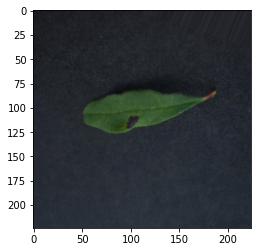

(32, 224, 224, 3)


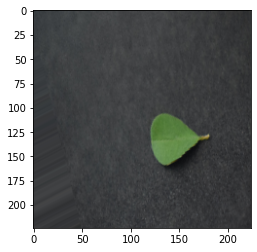

(32, 224, 224, 3)


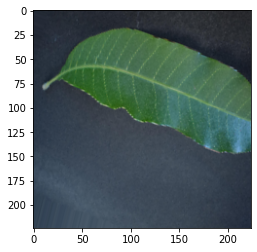

(32, 224, 224, 3)


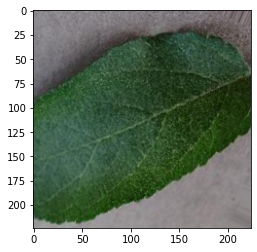

(32, 224, 224, 3)


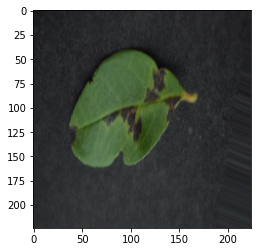

In [7]:
for _ in range(5):
    img, label = vgg16_model.train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Train Model

In [10]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
vgg16_model.train(model_name='vgg16', reduce_lr_config=reduce_lr_config)

Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 1.5479 - acc: 0.3956
Epoch 1: val_acc improved from -inf to 0.74961, saving model to vgg16-saved-model-01-acc-0.75.hdf5
71/71 [==============================] - 459s 6s/step - loss: 1.5479 - acc: 0.3956 - val_loss: 0.7506 - val_acc: 0.7496 - lr: 1.0000e-04
Epoch 2/20
71/71 [==============================] - ETA: 0s - loss: 0.9018 - acc: 0.6578
Epoch 2: val_acc improved from 0.74961 to 0.86299, saving model to vgg16-saved-model-02-acc-0.86.hdf5
71/71 [==============================] - 453s 6s/step - loss: 0.9018 - acc: 0.6578 - val_loss: 0.3893 - val_acc: 0.8630 - lr: 1.0000e-04
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 0.5634 - acc: 0.7978
Epoch 3: val_acc improved from 0.86299 to 0.89291, saving model to vgg16-saved-model-03-acc-0.89.hdf5
71/71 [==============================] - 456s 6s/step - loss: 0.5634 - acc: 0.7978 - val_loss: 0.3052 - val_acc: 0.8929 - lr: 1.0000e-04
Epoch 4/20
71/71 [=

## History

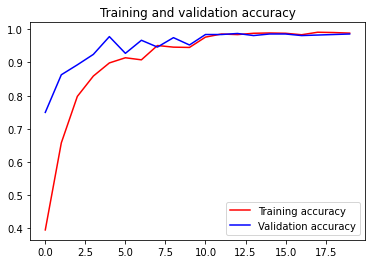

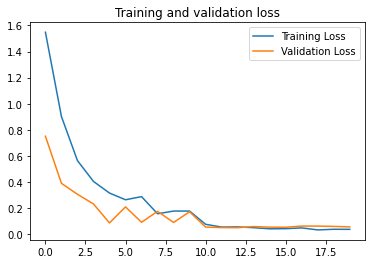

In [11]:
vgg16_model.plot_history()

## Evaluate Model

11/11 [==============================] - 187s 19s/step - loss: 0.0862 - acc: 0.9881
Loss of the model is -  0.08624332398176193
Accuracy of the model is -  98.81305694580078 %
              precision    recall  f1-score   support

      Anggur       1.00      1.00      1.00        37
        Apel       1.00      1.00      1.00        37
        Ceri       1.00      1.00      1.00        37
      Delima       1.00      1.00      1.00        37
    Jamblang       1.00      0.97      0.99        34
  Jambu Biji       0.96      0.98      0.97        50
     Kedelai       1.00      1.00      1.00        37
       Lemon       1.00      1.00      1.00        23
      Mangga       0.96      0.96      0.96        45

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337

Confusion Matrix


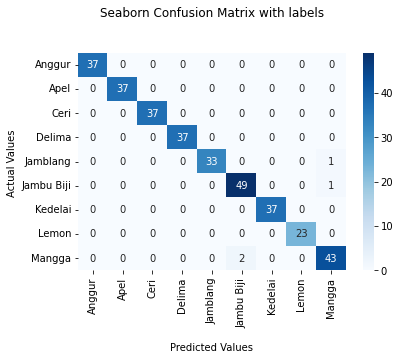

In [12]:
vgg16_model.evaluate_model()

In [13]:
vgg16_model.model.save_weights("/content/vgg16-saved-model-20-fixed3.hdf5")

In [14]:
!cp "/content/vgg16-saved-model-20-fixed3.hdf5" "/content/drive/Shareddrives/Bangkit Capstone/Best Model2"

In [ ]:
vgg16_model.model_name = 'vgg16'
vgg16_model.find_best_model('.')

AttributeError: ignored

## Evaluate Best Model

In [16]:
!cp "/content/vgg16-saved-model-13-acc-0.99.hdf5" "/content/drive/Shareddrives/Bangkit Capstone/Best Model2"

In [ ]:
vgg16_model.model.save("asd", save_format='tf')

INFO:tensorflow:Assets written to: asd/assets


In [ ]:
vgg16_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
vgg16_model.save_best_model(target_dir=target_dir)

# InceptionV3 (sucks)

## Build Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as iv3_preprocess_input

config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 8,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(learning_rate=0.0001),
    "metrics": ["accuracy"],
}

inceptionv3  = InceptionV3(weights="imagenet", include_top=False, input_shape=config['input_shape'],)
for layer in inceptionv3.layers[:249]:
   layer.trainable = False
for layer in inceptionv3.layers[249:]:
   layer.trainable = True

custom_layer = [
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]

iv3_model = Model(model=inceptionv3, config=config)
iv3_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=iv3_preprocess_input)
iv3_model.build_model(compile_config, custom_layer=custom_layer)

Found 1518 images belonging to 8 classes.
Found 427 images belonging to 8 classes.
Found 224 images belonging to 8 classes.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_12 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_2 (Dropout)         (None, 51200)             0         
                                                                 
 dense_33 (Dense)            (None, 512)               26214912  
                                                                 
 dense_34 (Dense)            (None, 1024)              525312    
                                                                 
 dense_35 (Dense)            (None, 1024)              104960

## Train Model

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
iv3_model.train('inceptionv3', reduce_lr_config=reduce_lr_config)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.5567 - acc: 0.3926
Epoch 1: val_acc improved from -inf to 0.30445, saving model to inceptionv3-saved-model-01-acc-0.30.hdf5
48/48 [==============================] - 235s 5s/step - loss: 1.5567 - acc: 0.3926 - val_loss: 1.7362 - val_acc: 0.3044 - lr: 1.0000e-04
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 1.2836 - acc: 0.4947
Epoch 2: val_acc improved from 0.30445 to 0.48478, saving model to inceptionv3-saved-model-02-acc-0.48.hdf5
48/48 [==============================] - 226s 5s/step - loss: 1.2836 - acc: 0.4947 - val_loss: 1.3601 - val_acc: 0.4848 - lr: 1.0000e-04
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 1.1994 - acc: 0.5244
Epoch 3: val_acc improved from 0.48478 to 0.49180, saving model to inceptionv3-saved-model-03-acc-0.49.hdf5
48/48 [==============================] - 227s 5s/step - loss: 1.1994 - acc: 0.5244 - val_loss: 1.2302 - val_acc: 0.4918 - lr: 1.0000e-04
E

## History

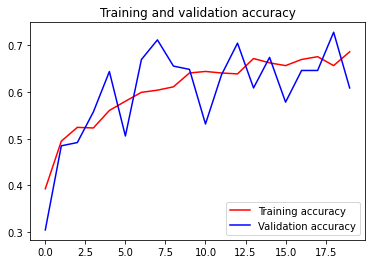

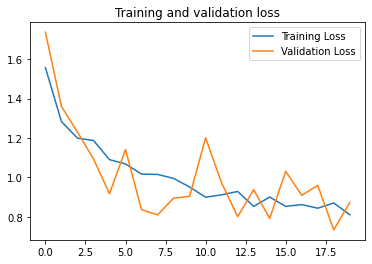

In [ ]:
iv3_model.plot_history()

## Evaluate Model

1/7 [===>..........................] - ETA: 29s - loss: 11.1516 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 24s 3s/step - loss: 8.4691 - acc: 0.1027
Loss of the model is -  8.469086647033691
Accuracy of the model is -  10.26785746216774 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.10      0.95      0.17        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.00      0.00      0.00        45
        Mint       0.00      0.00      0.00        45
      Pepaya       0.50      0.08      0.14        24

    accuracy                           0.10       224
   macro avg       0.07      0.13      0.04       224
weighted avg       0.06      0.10      0.03       224

Confusion Matrix


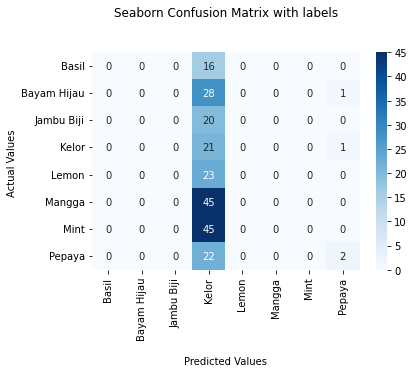

In [ ]:
iv3_model.evaluate_model()

## Evaluate Best Model

./inceptionv3-saved-model-19-acc-0.73.hdf5
1/7 [===>..........................] - ETA: 29s - loss: 11.4252 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 23s 3s/step - loss: 8.7554 - acc: 0.1295
Loss of the model is -  8.755419731140137
Accuracy of the model is -  12.94642835855484 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.10      0.86      0.17        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.00      0.00      0.00        45
        Mint       0.00      0.00      0.00        45
      Pepaya       0.37      0.42      0.39        24

    accuracy                           0.13       224
   macro avg       0.06      0.16      0.07       224
weighted avg       0.05      0.13      0.06       224

Confusion Matrix


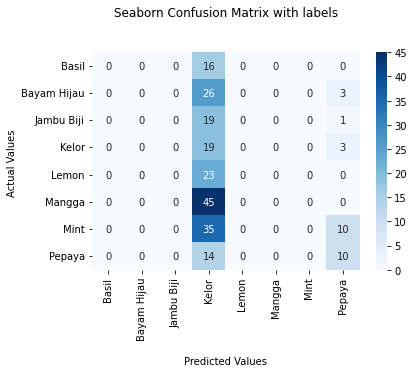

In [ ]:
iv3_model.model_name = 'inceptionv3'
iv3_model.find_best_model('.')
iv3_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
iv3_model.save_best_model(target_dir=target_dir)

Copy ./inceptionv3-saved-model-06-acc-0.68.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


# ResNet50

## Build Model

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
config = {
    "batch_size": 32,
    "trainable": False,
    "epochs": 20,
    "classes": 9,
    "input_shape": (224, 224, 3)

}

# compile_config = {
#     "loss": "sparse_categorical_crossentropy",
#     "optimizer": Adam(lr=1e-4),
#     "metrics": ["accuracy"],
# }

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]
resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=config['input_shape'],)
resnet50.trainable = False
resnet50_model = Model(model=resnet50, config=config)
resnet50_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=resnet50_preprocess_input)
resnet50_model.build_model(compile_config, custom_layer=custom_layer)

Found 2250 images belonging to 9 classes.
Found 635 images belonging to 9 classes.
Found 337 images belonging to 9 classes.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_16 (Dense)            (None, 512)               51380736  
                                                                 
 dense_17 (Dense)            (None, 1024)              525312    
                                                                 
 dense_18 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_19 (Dense)            (None, 9)                 9225   

## Train Model

In [28]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
resnet50_model.train('resnet50', reduce_lr_config=reduce_lr_config)

Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 2.1861 - acc: 0.1436
Epoch 1: val_acc improved from -inf to 0.24409, saving model to resnet50-saved-model-01-acc-0.24.hdf5
71/71 [==============================] - 464s 7s/step - loss: 2.1861 - acc: 0.1436 - val_loss: 2.1448 - val_acc: 0.2441 - lr: 2.0000e-06
Epoch 2/20
71/71 [==============================] - ETA: 0s - loss: 2.1412 - acc: 0.1893
Epoch 2: val_acc improved from 0.24409 to 0.37480, saving model to resnet50-saved-model-02-acc-0.37.hdf5
71/71 [==============================] - 457s 6s/step - loss: 2.1412 - acc: 0.1893 - val_loss: 2.0783 - val_acc: 0.3748 - lr: 2.0000e-06
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 2.1077 - acc: 0.2004
Epoch 3: val_acc did not improve from 0.37480
71/71 [==============================] - 468s 7s/step - loss: 2.1077 - acc: 0.2004 - val_loss: 2.0373 - val_acc: 0.2724 - lr: 2.0000e-06
Epoch 4/20
71/71 [==============================] - ETA: 0s - loss: 2

KeyboardInterrupt: ignored

## History

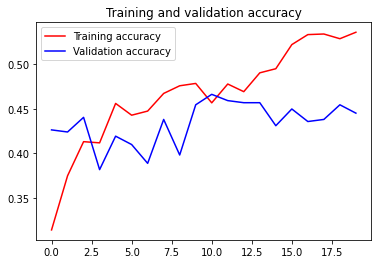

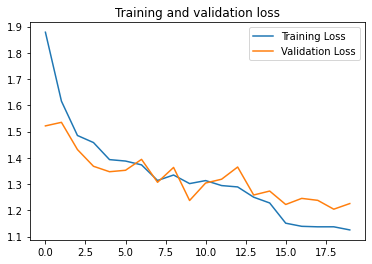

In [ ]:
resnet50_model.plot_history()

## Evaluate Model

1/7 [===>..........................] - ETA: 31s - loss: 1.6835 - acc: 0.0938

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 24s 3s/step - loss: 1.3344 - acc: 0.4554
Loss of the model is -  1.33437979221344
Accuracy of the model is -  45.53571343421936 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.23      0.10      0.14        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.26      0.77      0.39        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.60      1.00      0.75        45
        Mint       0.51      0.51      0.51        45
      Pepaya       0.54      0.58      0.56        24

    accuracy                           0.46       224
   macro avg       0.27      0.37      0.29       224
weighted avg       0.34      0.46      0.37       224

Confusion Matrix


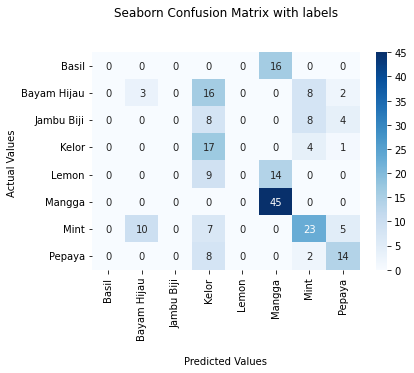

In [ ]:
resnet50_model.evaluate_model()

## Evaluate Best Model

./resnet50-saved-model-11-acc-0.47.hdf5
1/7 [===>..........................] - ETA: 31s - loss: 1.8790 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 25s 3s/step - loss: 1.3031 - acc: 0.4554
Loss of the model is -  1.3030669689178467
Accuracy of the model is -  45.53571343421936 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.24      0.59      0.34        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.60      1.00      0.75        45
        Mint       0.52      0.53      0.53        45
      Pepaya       0.45      0.83      0.59        24

    accuracy                           0.46       224
   macro avg       0.23      0.37      0.28       224
weighted avg       0.30      0.46      0.35       224

Confusion Matrix


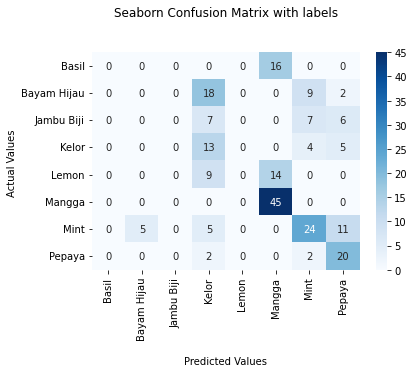

In [ ]:
resnet50_model.model_name = 'resnet50'
resnet50_model.find_best_model('.')
resnet50_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
resnet50_model.save_best_model(target_dir=target_dir)

Copy ./resnet50-saved-model-11-acc-0.47.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


# VGG19

## Build Model

In [29]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input

# config = {
#     "batch_size": 32,
#     "epochs": 20,
#     "classes": 10,
#     "input_shape": (224, 224, 3)

# }

# compile_config = {
#     "loss": "sparse_categorical_crossentropy",
#     "optimizer": Adam(),
#     "metrics": ["accuracy"],
# }
vgg19 = VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=config['input_shape'],
)

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
]

vgg19.trainable = False
vgg19_model = Model(model=vgg19, config=config)
vgg19_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg19_preprocess_input)
vgg19_model.build_model(compile_config, custom_layer)

80150528/80134624 [==============================] - 0s 0us/step
Found 2250 images belonging to 9 classes.
Found 635 images belonging to 9 classes.
Found 337 images belonging to 9 classes.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_20 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 1024)              525312    
                                                               

## Train Model

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
vgg19_model.train('vgg19', reduce_lr_config=reduce_lr_config)

Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 2.0654 - acc: 0.2440
Epoch 1: val_acc improved from -inf to 0.57323, saving model to vgg19-saved-model-01-acc-0.57.hdf5
71/71 [==============================] - 470s 7s/step - loss: 2.0654 - acc: 0.2440 - val_loss: 1.7576 - val_acc: 0.5732 - lr: 2.0000e-06
Epoch 2/20
71/71 [==============================] - ETA: 0s - loss: 1.8131 - acc: 0.3867
Epoch 2: val_acc improved from 0.57323 to 0.64724, saving model to vgg19-saved-model-02-acc-0.65.hdf5
71/71 [==============================] - 461s 7s/step - loss: 1.8131 - acc: 0.3867 - val_loss: 1.5174 - val_acc: 0.6472 - lr: 2.0000e-06
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 1.6576 - acc: 0.4729
Epoch 3: val_acc improved from 0.64724 to 0.72126, saving model to vgg19-saved-model-03-acc-0.72.hdf5
71/71 [==============================] - 465s 7s/step - loss: 1.6576 - acc: 0.4729 - val_loss: 1.3517 - val_acc: 0.7213 - lr: 2.0000e-06
Epoch 4/20
71/71 [=

## History

In [ ]:
vgg19_model.plot_history()

## Evaluate Model

In [ ]:
vgg19_model.evaluate_model()

In [ ]:
vgg19_model.model.save_weights("/content/vgg19-saved-model-20-fixed.hdf5")
!cp "/content/vgg16-saved-model-20-fixed3.hdf5" "/content/drive/Shareddrives/Bangkit Capstone/Best Model2"

## Evaluate Best Model

In [ ]:
vgg19_model.model_name = 'vgg19'
vgg19_model.find_best_model('.')
vgg19_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model2'
vgg19_model.save_best_model(target_dir=target_dir)

# Predict Image

In [ ]:
vgg16_model.model.load_weights("/content/vgg16-saved-model-16-acc-0.99.hdf5")

In [17]:
def load_image(img_path, show=False):

    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [19]:
!wget https://live.staticflickr.com/8095/8579904723_b5c6aeff68_b.jpg -O croffle.png

--2022-06-10 16:31:19--  https://live.staticflickr.com/8095/8579904723_b5c6aeff68_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 52.84.159.78, 2600:9000:2377:3400:0:5a51:64c9:c681, 2600:9000:2377:c800:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|52.84.159.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘croffle.png’

croffle.png             [ <=>                ] 176.64K  --.-KB/s    in 0.02s   

2022-06-10 16:31:19 (9.58 MB/s) - ‘croffle.png’ saved [180876]



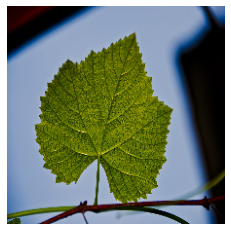

Anggur
Anggur: 45.74139714241028
Apel: 33.868661522865295
Ceri: 0.040324911242350936
Delima: 0.021648935216944665
Jamblang: 0.0652325979899615
Jambu Biji: 0.4721820820122957
Kedelai: 0.003595182715798728
Lemon: 18.63328218460083
Mangga: 1.1536677367985249


In [20]:
model = vgg16_model.model
label_map = (vgg16_model.train_generator.class_indices)
label_map = {v: k for k, v in label_map.items()}
image_path ='croffle.png'
image = load_image(image_path, show=True)
predict = model.predict(image)
print(label_map[np.argmax(model.predict(image))])
predicted_list = [ele * 100 for ele in predict.flatten()]

for idx, ele in enumerate(predicted_list):
  print(f"{label_map[idx]}: {ele}")

In [21]:
def predict_false_images(images):
  model = vgg16_model.model
  label_map = (vgg16_model.train_generator.class_indices)
  label_map = {v: k for k, v in label_map.items()}
  # image_path ='/content/drive/Shareddrives/Bangkit Capstone/Plant_leave_diseases_dataset_without_augmentation/Background_without_leaves/image (138).jpg'
  count = 0
  image_files = os.listdir(images)
  for img in image_files:
    image = os.path.join(images, img)
    image = load_image(image, show=False)
    predict = model.predict(image)
    # label_predict = label_map[np.argmax(predict)]
    predicted_list = [ele * 100 for ele in predict.flatten()]
    max_pred_acc = max(predicted_list)
  
    if max_pred_acc >=80:
      count += 1
  
  print(f"False predicted image  = {count} from {len(image_files)}")
  

predict_false_images('/content/drive/Shareddrives/Bangkit Capstone/Plant_leave_diseases_dataset_without_augmentation/Background_without_leaves/') 

False predicted image  = 873 from 1143


# Save Model

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 40 kB 5.9 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
vgg16_model.model.save("asd", save_format='tf')

INFO:tensorflow:Assets written to: asd/assets


In [ ]:
!tensorflowjs_converter --input_format tf_saved_model --output_format tfjs_graph_model asd vgg16_saved_model

2022-06-07 08:39:14.320473: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-07 08:39:15.869340: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:16.015684: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:16.108850: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:16.598163: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:19.941624: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
Writing weight file vgg16_saved_model/model.json...


In [ ]:
!zip -r vgg16_best_model_last.zip vgg16_saved_model

  adding: vgg16_saved_model/ (stored 0%)
  adding: vgg16_saved_model/group1-shard16of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard2of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard10of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard3of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard7of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard25of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard8of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard27of28.bin (deflated 8%)
  adding: vgg16_saved_model/group1-shard12of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard28of28.bin (deflated 8%)
  adding: vgg16_saved_model/group1-shard17of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard20of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard23of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard5of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard14of28.bin (de

In [ ]:
!cp vgg16_best_model_last.zip /content/drive/Shareddrives/Bangkit\ Capstone/Saved\ model

# Miscellaneous

In [ ]:
vgg16_model.train_generator.class_indices

{'Anggur': 0,
 'Apel': 1,
 'Ceri': 2,
 'Delima': 3,
 'Jamblang': 4,
 'Jambu Biji': 5,
 'Kedelai': 6,
 'Lemon': 7,
 'Mangga': 8,
 'Pepaya': 9}

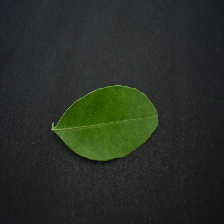

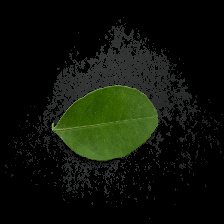

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img =  cv2.imread('/content/drive/Shareddrives/Bangkit Capstone/Final_Split_Datasets/train/Lemon/0010_0001.JPG')
img = cv2.resize(img, (224,224))
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# find the green color 
mask_green = cv2.inRange(hsv,(36,0,0), (86,255,255))
# find the brown color
mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
# find the yellow color in the leaf
mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

# find any of the three colors(green or brown or yellow) in the image
mask = cv2.bitwise_or(mask_green, mask_brown)
mask = cv2.bitwise_or(mask, mask_yellow)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(img,img, mask= mask)

cv2_imshow(img)
cv2_imshow(res)
# cv2_imshow(processedimage)
cv2.waitKey(0)
cv2.destroyAllWindows()

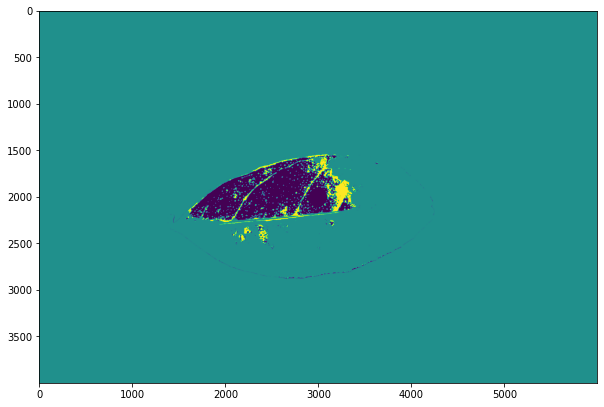

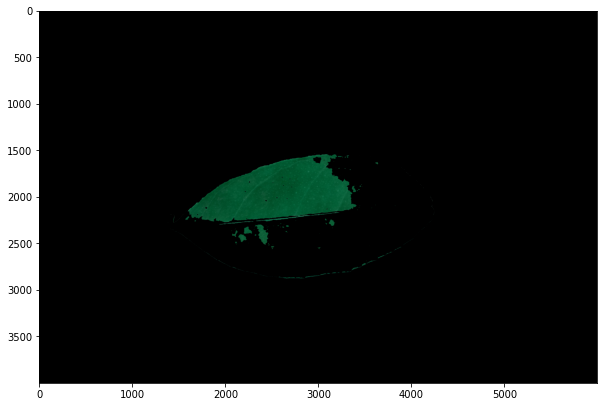

In [ ]:
def mask_leaf(im_name, external_mask=None):

    im = cv2.imread(im_name)
    im = cv2.blur(im, (5,5))

    height, width = im.shape[:2]

    mask = np.ones(im.shape[:2], dtype=np.uint8) * 2 #start all possible background
    '''
    #from docs:
    0 GC_BGD defines an obvious background pixels.
    1 GC_FGD defines an obvious foreground (object) pixel.
    2 GC_PR_BGD defines a possible background pixel.
    3 GC_PR_FGD defines a possible foreground pixel.
    '''

    #2 circles are "drawn" on mask. a smaller centered one I assume all pixels are definite foreground. a bigger circle, probably foreground.
    r = 100
    cv2.circle(mask, (int(width/2.), int(height/2.)), 2*r, 3, -3) #possible fg
    #next 2 are greens...dark and bright to increase the number of fg pixels.
    mask[(im[:,:,0] < 45) & (im[:,:,1] > 55) & (im[:,:,2] < 55)] = 1  #dark green
    mask[(im[:,:,0] < 190) & (im[:,:,1] > 190) & (im[:,:,2] < 200)] = 1  #bright green
    mask[(im[:,:,0] > 200) & (im[:,:,1] > 200) & (im[:,:,2] > 200) & (mask != 1)] = 0 #pretty white

    cv2.circle(mask, (int(width/2.), int(height/2.)), r, 1, -3) #fg

    #if you pass in an external mask derived from some other operation it is factored in here.
    if external_mask is not None:
        mask[external_mask == 1] = 1

    bgdmodel = np.zeros((1,65), np.float64)
    fgdmodel = np.zeros((1,65), np.float64)
    cv2.grabCut(im, mask, None, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)

    #show mask
    plt.figure(figsize=(10,10))
    plt.imshow(mask)
    plt.show()

    #mask image
    mask2 = np.where((mask==1) + (mask==3), 255, 0).astype('uint8')
    output = cv2.bitwise_and(im, im, mask=mask2)
    plt.figure(figsize=(10,10))
    plt.imshow(output)
    plt.show()

mask_leaf('/content/drive/Shareddrives/Bangkit Capstone/Final_Split_Datasets/train/Lemon/0010_0001.JPG', external_mask=None)
# mask_leaf('leaf2.jpg', external_mask=None)

In [ ]:
train_generator.class_indices

{'Bayam Hijau': 0,
 'Jahe': 1,
 'Jambu Biji': 2,
 'Jeruk Purut': 3,
 'Kelor': 4,
 'Kersen': 5,
 'Lemon': 6,
 'Lengkuas': 7,
 'Mint': 8,
 'Nangka': 9,
 'Pepaya': 10}